In [ ]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
import random
random.seed(42)


from utils import (
    GroundtruthKernels,
    ModulationFunctions,
    get_U_matrix,
    get_random_feature,
    simulate_walks_from_all,
    adj_matrix_to_lists,
    frob_norm_error,
)

### Unbiased pointwise estimation of fixed kernels

In [3]:
# Choose the hyperparameters.
sigma = 0.25  # Scalar regulariser <1 to ensure that the groundtruth kernels converge
alpha = 20
p_halt = 0.1  # Walker termination probability
nb_random_walks = [2, 4, 8, 16]  # Numbers of random walks /node to sample.
trials = 10  # Number of repeats per number of walks per graph.

ground_truth = GroundtruthKernels(sigma=sigma, alpha=alpha)
modulation_funcs = ModulationFunctions()

# 8 example graphs
adj_matrices = np.load("data/adj_matrices.npy", allow_pickle=True)

In [4]:
# Approximate the graph kernels using the GRFs method.

# Holders for approximation error means and standard deviations.
graphs_all_means = []
graphs_all_stds = []

for graph_id, W in enumerate(adj_matrices, start=1):
    print(f"Approximating kernels for graph {graph_id} of 8...")
    all_errors = []
    all_stds = []

    for kernel_index in range(1, 6):
        U = get_U_matrix(W)  # Normalise the adjacency matrix
        groundtruth, U = ground_truth.get_groundtruth_kernel(
            kernel_index, U
        )  # Compute groundtruth kernel
        adj_lists, weight_lists = adj_matrix_to_lists(U)  # Get the adjacency and weights lists

        # Instantiate lists to hold errors
        errors_log = []
        stds_log = []

        for walks in nb_random_walks:
            errors = []

            for trial in range(trials):
                all_walks_list = simulate_walks_from_all(adj_lists, p_halt, walks)  # Compute the walks
                A = get_random_feature(
                    U, adj_lists, p_halt, all_walks_list, modulation_funcs.functions[kernel_index]
                )  # Approximate the Gram matrix using GRFs
                
                # all_walks_list = simulate_walks_from_all(adj_lists, p_halt, walks)  # Compute the walks
                # B = get_random_feature(
                #     U, adj_lists, p_halt, all_walks_list, modulation_funcs.functions[kernel_index]
                # )  # Approximate the Gram matrix using GRFs
                approx_mat = A @ A.T
                errors.append(
                    frob_norm_error(groundtruth, approx_mat) ** 2
                )  # Record the approximation error
            errors_log.append(np.mean(errors))
            stds_log.append(np.std(errors) / np.sqrt(trials))

        all_errors.append(errors_log)
        all_stds.append(stds_log)

    all_errors = np.asarray(all_errors)
    all_stds = np.asarray(all_stds)

    graphs_all_means.append(all_errors)
    graphs_all_stds.append(all_stds)

print("Done.")

Approximating kernels for graph 1 of 8...
Approximating kernels for graph 2 of 8...
Approximating kernels for graph 3 of 8...
Approximating kernels for graph 4 of 8...
Approximating kernels for graph 5 of 8...
Approximating kernels for graph 6 of 8...
Approximating kernels for graph 7 of 8...
Approximating kernels for graph 8 of 8...
Done.


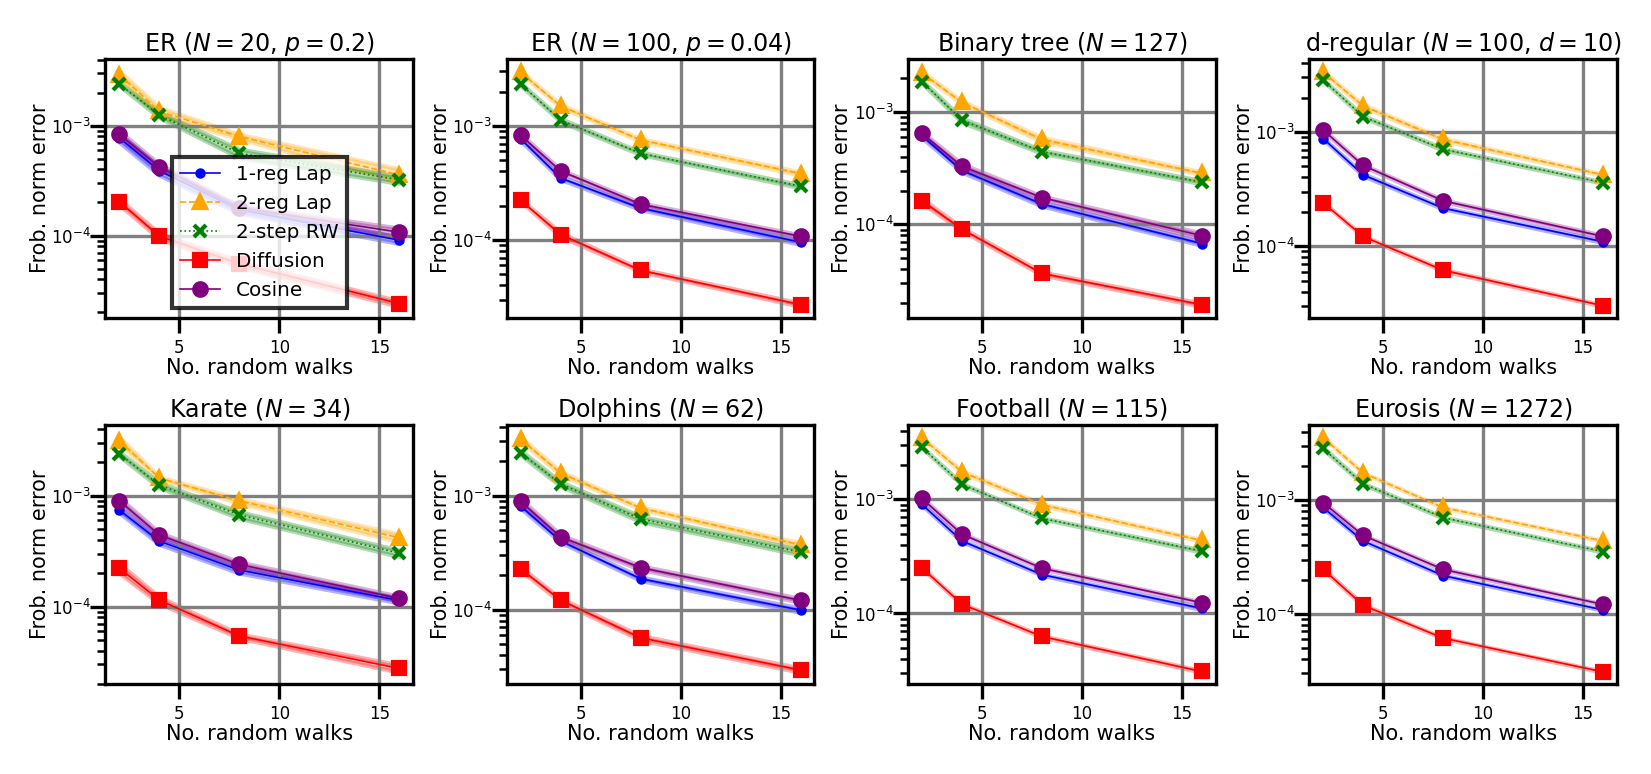

In [5]:
def do_single_plot(ax, means, stds, nb_rnd_walks_list):
    """
    Plotting func for data from GRFs experiment.
    """
    linestyles = ["solid", "dashed", "dotted", "solid", "solid"]
    labels = ["1-reg Lap", "2-reg Lap", "2-step RW", "Diffusion", "Cosine"]
    markers = [".", "^", "x", "s", "o"]
    colors = ["blue", "orange", "green", "red", "purple"]

    nb_rnd_walks_list = np.asarray(nb_rnd_walks_list)
    means = np.asarray(means)
    stds = np.asarray(stds)

    for i in range(5):
        ax.plot(
            nb_rnd_walks_list,
            means[i],
            label=labels[i],
            linestyle=linestyles[i],
            marker=markers[i],
            markersize=3,
            color=colors[i],
        )
        ax.fill_between(
            nb_rnd_walks_list, means[i] - stds[i], means[i] + stds[i], alpha=0.3, color=colors[i]
        )

    ax.set_xlabel("No. random walks", labelpad=0.25, size=5, color="black")
    ax.set_ylabel("Frob. norm error", labelpad=0.25, size=5, color="black")
    ax.grid(color="grey")

rc_temp = {
    "font.size": 4,
    "lines.linewidth": 0.4,
    "xtick.major.pad": 1.5,
    "ytick.major.pad": 0,
    "ytick.minor.pad": 0,
    "ytick.minor.width": 0.6,
    "legend.fancybox": False,
    "legend.framealpha": 0.8,
    "legend.fontsize": "large",
    "legend.edgecolor": "black",
    "legend.facecolor": "white",
    "figure.facecolor": "white",
    "text.color": "black",
}

with plt.rc_context(rc_temp):
    fig, axes = plt.subplots(2, 4, figsize=(5.41, 2.5), dpi=300)
    titles = [
        "ER ($N=20$, $p=0.2$)",
        "ER ($N=100$, $p=0.04$)",
        "Binary tree ($N=127$)",
        "d-regular ($N=100$, $d=10$)",
        "Karate ($N=34$)",
        "Dolphins ($N=62$)",
        "Football ($N=115$)",
        "Eurosis ($N=1272$)",
    ]

    for graph_id, ax in enumerate(axes.flatten()):
        
        do_single_plot(
            ax, 
            graphs_all_means[graph_id], 
            graphs_all_stds[graph_id], 
            nb_random_walks
        )
        
        if graph_id == 0:
            ax.legend()
        ax.set_title(titles[graph_id], pad=2, fontsize=5.7)
        ax.set_yscale("log")


    for ax in axes.flatten():
        ax.set_facecolor("white")
        ax.tick_params(colors="black", which="both")  # Set tick colors to black
        ax.spines["bottom"].set_color("black")  # Set bottom spine to black
        ax.spines["left"].set_color("black")  # Set left spine to black
        ax.spines["top"].set_color("black")  # Set bottom spine to black
        ax.spines["right"].set_color("black")  # Set left spine to black


    fig.tight_layout() 
    plt.show()

### Solving differential equations on graphs

In [ ]:
from scipy.integrate import solve_ivp


def solution(W: np.ndarray, y: np.ndarray, t: float) -> np.ndarray:
    def f(t, x):
        return W @ x + y

    x0 = np.zeros(W.shape[0])

    sol = solve_ivp(f, (0, t), x0, method="BDF")
    return sol.y[:, -1]


def estimate_solution(
    W: np.ndarray, y: np.ndarray, p_halt: float, n_walks: int, t: float, n: int
) -> np.ndarray:
    """
    Estimate the solution of the ODE: dx(t)/dt = Wx(t) + y(t), assume x(0) = 0.
    x(t) = E[exp(W(t - k) * y(k))] via Monte Carlo, where
    exp(W(t - k) is estimated via g-GRFs.

    Args:
        W (np.ndarray): W or L, the notation is ambiguous in the paper.
            Here we use W as the normalised adjacency matrix.
        y (np.ndarray): The driving term vector.
        p_halt (float): The walker termination probability.
        n_walks (int): The number of random walks per node.
        t (float): The time parameter.
        n (int): The number of Monte Carlo samples.
    """
    res = np.zeros_like(y, dtype=np.float64)

    for _ in range(n):
        k = 0.5 + t / n  # use discretization instead of random sampling
        adj_lists, _ = adj_matrix_to_lists(W)
        W_p = W * (t - k)
        all_walks_list = simulate_walks_from_all(adj_lists, p_halt, n_walks)
        phi = get_random_feature(W_p, adj_lists, p_halt, all_walks_list, f=modulation_funcs.diffusion)
        res += phi @ (phi.T @ y) * np.exp(k - t)

    return res / n

In [11]:
# Karate, Dolphins, Football
adj_matrices = np.load("data/adj_matrices.npy", allow_pickle=True)[4:7]
t = 1.0
n = 10
trails = 100
nb_random_walks = [2, 4, 8, 16]

In [12]:
graph_errors_mean = []
graph_errors_std = []

for adj in adj_matrices:
    W = get_U_matrix(adj)
    N = W.shape[0]
    E = np.eye(N)

    y = np.zeros(N)
    y[0] = 1.0
    x_true = solution(W - E, y, t)  # use W = - L

    walk_errors_mean = []
    walk_errors_std = []
    for n_walks in nb_random_walks:
        errors = []
        for _ in range(trails):
            x_est = estimate_solution(
                W=W,
                y=y,
                p_halt=0.1,
                n_walks=n_walks,
                t=t,
                n=n,
            )
            error = (np.linalg.norm(x_true - x_est) / np.linalg.norm(x_true))
            errors.append(error)
        walk_errors_mean.append(np.mean(errors))
        walk_errors_std.append(np.std(errors) / np.sqrt(trails))

    graph_errors_mean.append(walk_errors_mean)
    graph_errors_std.append(walk_errors_std)

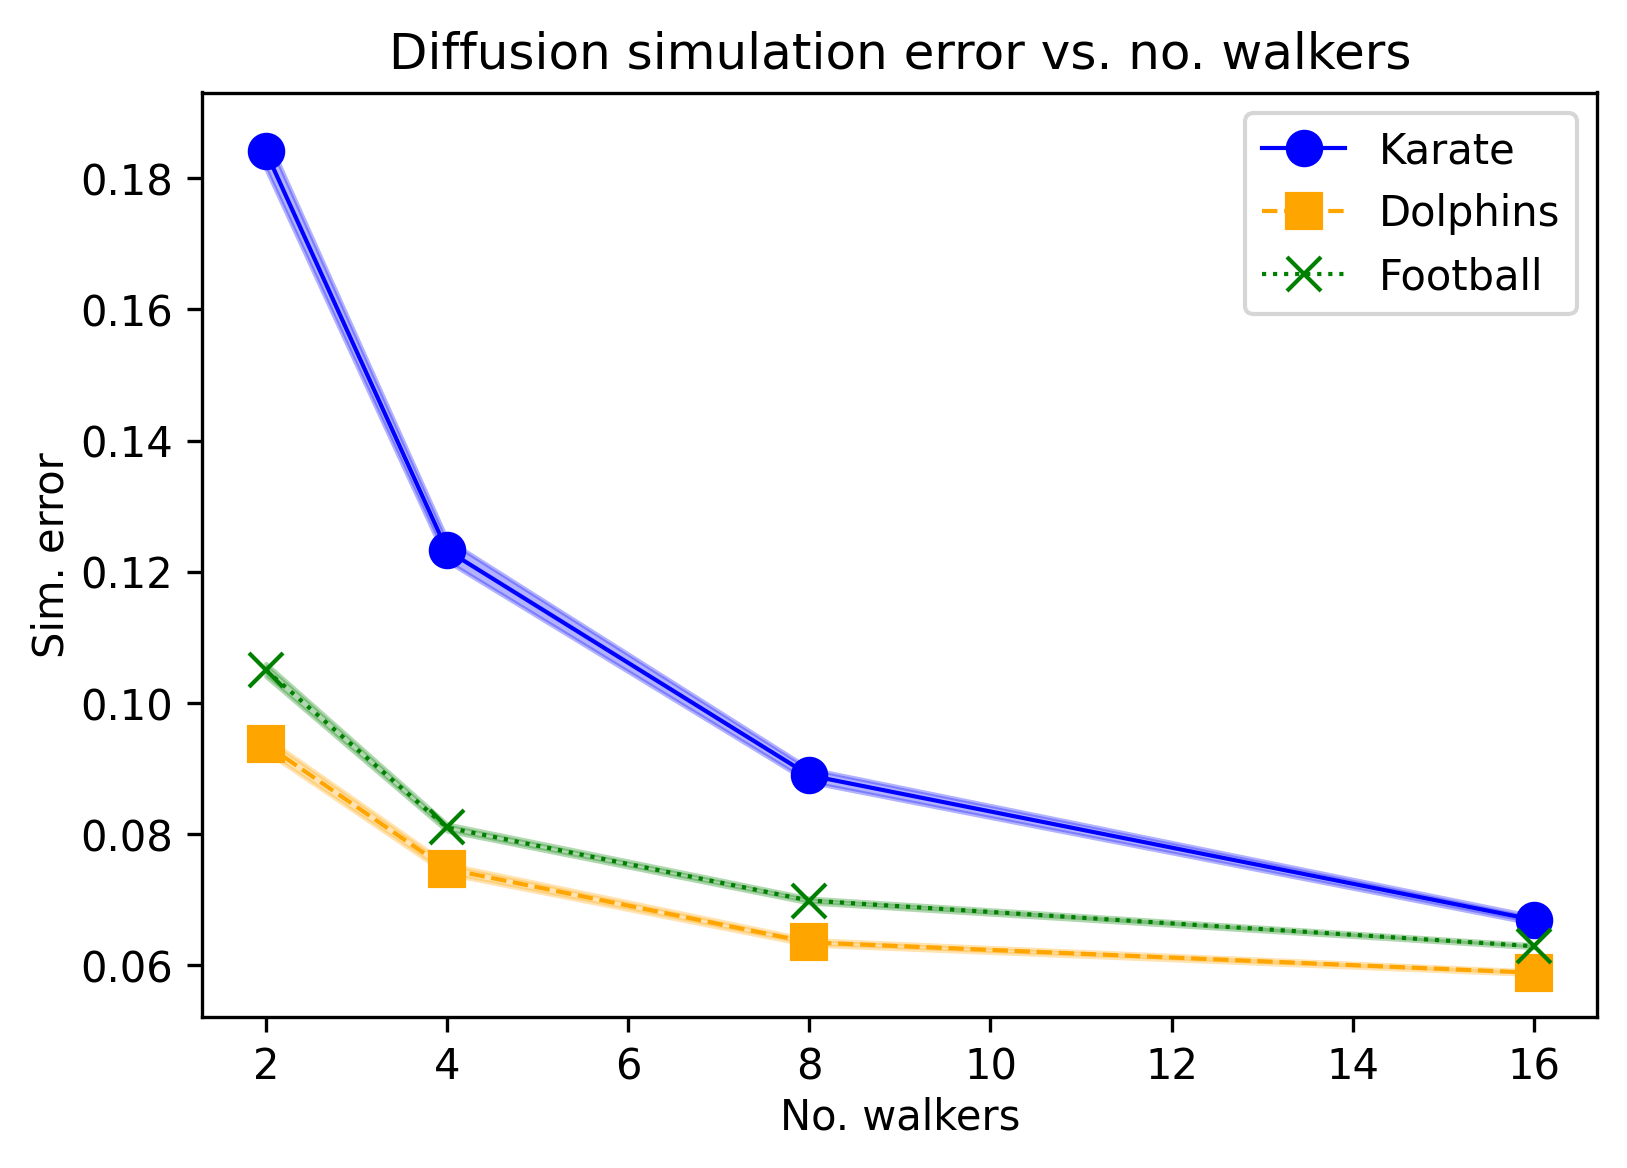

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
labels = ["Karate", "Dolphins", "Football"]
markers = ["o", "s", "x"]
line_styles = ["solid", "dashed", "dotted"]
colors = ["blue", "orange", "green"]
for i in range(3):
    ax.plot(
        nb_random_walks,
        graph_errors_mean[i],
        label=labels[i],
        linestyle=line_styles[i],
        marker=markers[i],
        markersize=8,
        color=colors[i],
        linewidth=1,
    )
    ax.fill_between(
        nb_random_walks,
        np.array(graph_errors_mean[i]) - np.array(graph_errors_std[i]),
        np.array(graph_errors_mean[i]) + np.array(graph_errors_std[i]),
        alpha=0.3,
        color=colors[i],
    )
ax.set_xlabel("No. walkers", labelpad=2, size=10, color="black")
ax.set_ylabel("Sim. error", labelpad=2, size=10, color="black")
ax.legend()
ax.set_title("Diffusion simulation error vs. no. walkers")
plt.show()

### Efficient kernelised graph node clustering

#### Kernel K-means

Input
- $K$: Kernel matrix
- $k$: Number of clusters

Output
- $C_1, \dots, C_k$: Partitioning of the points

Algorithm Steps
1. Initialization: Initialize the $k$ clusters:$$C^{(0)}_1, \dots, C^{(0)}_k$$
2. Set $t = 0$.
3. Re-assignment Step: For each point $a$, find its new cluster index $j^\ast(a)$ by minimizing the distance to the cluster center $\mu_j$:$$j^\ast(a) = \underset{j}{\operatorname{argmin}} \left\lVert \phi(a) - \mu_j \right\rVert^2$$
$$\mu_j = \frac{1}{| \pi_j |} \sum_{b \in \pi_j} \phi(b)$$
$$\left\lVert \phi(a) - \mu_j \right\rVert^2 = \phi(a)\cdot \phi(a) - 2 \frac{\sum_{b \in \pi_j} \phi(a)\cdot \phi(b)}{|\pi_j|} + \frac{\sum_{b, c \in \pi_j} \phi(b)\cdot \phi(c)}{|\pi_j|^2}$$
$$\left\lVert \phi(a) - \mu_j \right\rVert^2 = K_{aa} - 2 \frac{\sum_{b \in \pi_j} K_{ab}}{|\pi_j|} + \frac{\sum_{b, c \in \pi_j} K_{bc}}{|\pi_j|^2}$$
4. Cluster Update: Compute the updated clusters $C^{t+1}_j$:$$C^{t+1}_j = \left\{ a : j^\ast(a) = j \right\}$$
5. Convergence Check: If not converged, set $t = t + 1$ and go to Step 3; Otherwise, stop.

In [101]:
def reassign(K: np.ndarray, clusters: np.ndarray, num_clusters: int) -> np.ndarray:
    indicate = np.eye(num_clusters)[clusters, :]  # shape: (n, k)
    cluster_sizes = indicate.sum(axis=0, keepdims=True)  # shape: (1, k)
    # term1 = diag(K)
    # term2 = -2 * K @ indicate / cluster_sizes
    # term3 = diag(ind.T @ K @ ind) / (cluster_sizes ** 2)
    distances = (
        np.diag(K)[:, np.newaxis]
        - 2 * K @ indicate / cluster_sizes
        + np.diag(indicate.T @ K @ indicate)[np.newaxis, :] / (cluster_sizes ** 2)
    )  # shape: (n, k)
    term1 = np.diag(K)
    # print(f"Term1: {term1}")
    term2 = -2 * K @ indicate / cluster_sizes
    # print(f"Term2: {term2}")
    term3 = np.diag(indicate.T @ K @ indicate)[np.newaxis, :] / (cluster_sizes ** 2)
    # print(f"Term3: {term3}")
    # print(f"Distances: {distances}")

    return np.argmin(distances, axis=1)


def weighted_kernel_kmeans(
    K: np.ndarray, num_clusters: int, max_iters: int = -1
) -> np.ndarray:
    """
    Weighted kernel k-means clustering.

    Args:
        K (np.ndarray): The kernel matrix.
        num_clusters (int): The number of clusters.
        max_iters (int): The maximum number of iterations. If <=0, run until convergence.
    """

    n = K.shape[0]
    clusters = np.random.randint(0, num_clusters, size=n)
    t = 0
    while max_iters <= 0 or t < max_iters:
        new_clusters = reassign(K, clusters, num_clusters)
        if np.all(new_clusters == clusters):
            break
        clusters = new_clusters
        t += 1
        print(f"Iteration {t}: cluster: {clusters}")
    
    return clusters

In [102]:
# Example usage
adj = adj_matrices[1]

In [ ]:
K = scipy.linalg.expm(adj * 0.2)

In [104]:
adj

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(62, 62))

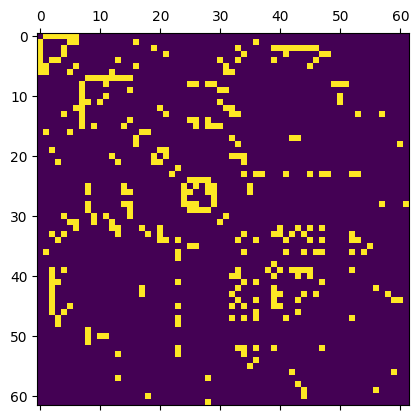

In [105]:
plt.matshow(adj)
plt.show()

In [106]:
K

array([[1.41110636e-01, 2.61885230e-01, 2.60024052e-01, ...,
        2.10718816e-03, 2.34133795e-03, 8.05375649e-06],
       [2.61885230e-01, 1.15606791e-01, 3.44800512e-02, ...,
        1.53787083e-03, 2.98291734e-03, 1.21622485e-06],
       [2.60024052e-01, 3.44800512e-02, 3.16235290e-01, ...,
        2.84376103e-02, 2.87129261e-02, 1.14951871e-05],
       ...,
       [2.10718816e-03, 1.53787083e-03, 2.84376103e-02, ...,
        4.07967711e-02, 2.07324038e-02, 1.34096428e-07],
       [2.34133795e-03, 2.98291734e-03, 2.87129261e-02, ...,
        2.07324038e-02, 4.09981433e-02, 2.36984638e-07],
       [8.05375649e-06, 1.21622485e-06, 1.14951871e-05, ...,
        1.34096428e-07, 2.36984638e-07, 2.06914950e-02]], shape=(62, 62))

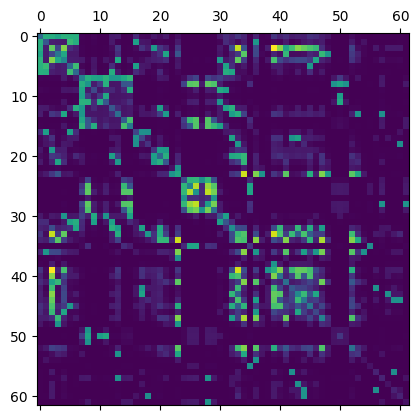

In [107]:
plt.matshow(K)
plt.show()

In [114]:
weighted_kernel_kmeans(K, num_clusters=3)

Iteration 1: cluster: [0 0 0 1 0 0 1 1 2 1 1 1 1 1 2 1 0 0 2 0 1 2 2 0 2 2 2 2 2 2 0 1 1 1 1 2 1
 2 2 0 0 2 2 0 0 2 0 2 2 0 0 0 2 1 0 2 0 1 0 1 0 2]
Iteration 2: cluster: [0 0 0 2 0 0 1 1 2 1 1 1 1 1 2 2 0 0 0 0 1 1 0 2 2 2 2 2 2 2 1 1 1 0 1 2 0
 0 0 0 0 1 0 0 0 0 0 1 2 2 1 2 1 1 1 2 2 2 0 0 0 2]
Iteration 3: cluster: [0 0 0 1 0 0 1 1 2 1 1 1 1 1 2 2 0 0 0 1 1 1 2 1 2 2 2 2 2 2 1 1 1 0 1 2 1
 2 0 0 0 1 0 0 0 0 0 1 2 2 1 2 0 1 0 2 0 2 0 0 0 2]
Iteration 4: cluster: [0 0 0 1 0 0 1 1 2 1 1 1 1 1 2 2 0 0 0 1 1 1 1 1 2 2 2 2 2 2 1 1 1 0 1 2 1
 1 0 0 0 1 0 0 0 0 0 1 1 2 1 2 1 1 1 2 0 2 0 0 0 2]


array([0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 2])

In [83]:
import numpy as np
from numpy import linalg as LA

# [ ... reassign 函数保持不变 ... ]
# (保持了您原始的 reassign 函数，但请记住它有零除风险)

def reassign(K: np.ndarray, clusters: np.ndarray, num_clusters: int) -> np.ndarray:
    indicate = np.eye(num_clusters)[clusters, :]  # shape: (n, k)
    cluster_sizes = indicate.sum(axis=0, keepdims=True)  # shape: (1, k)
    
    # 警告：此处的除法存在 ZeroDivisionError 或产生 NaN 的风险，但按用户要求保留原样
    distances = (
        np.diag(K)[:, np.newaxis]
        - 2 * K @ indicate / cluster_sizes
        + np.diag(indicate.T @ K @ indicate)[np.newaxis, :] / (cluster_sizes ** 2)
    )  # shape: (n, k)

    return np.argmin(distances, axis=1)


def weighted_kernel_kmeans(
    K: np.ndarray, num_clusters: int, max_iters: int = -1
) -> np.ndarray:
    """
    Standard Kernel K-means clustering with Spectral Initialization.

    Args:
        K (np.ndarray): The kernel matrix.
        num_clusters (int): The number of clusters (k).
        max_iters (int): The maximum number of iterations. If <=0, run until convergence.
    """

    n = K.shape[0]
    
    # === 1. 谱聚类初始化部分 (Spectral Initialization) ===
    print("--- Starting Spectral Initialization ---")
    
    # 步骤 1 & 2: 对 K 矩阵进行特征值分解并选取前 k 个特征向量
    # eigenvalues 是特征值，eigenvectors 是对应的特征向量 (按列排列)
    # 使用 eigh 针对对称矩阵 (K 是对称的)
    eigenvalues, eigenvectors = LA.eigh(K)
    
    # 选取 k 个最大的特征值对应的特征向量
    # 特征值通常是升序排列的，所以我们取最后 k 列
    top_k_indices = np.argsort(eigenvalues)[-num_clusters:]
    
    # U 是降维空间中的嵌入矩阵 (N x k)
    U = eigenvectors[:, top_k_indices]
    
    # 步骤 3: 在降维空间 U 上运行标准 K-均值
    # 使用 np.random.choice 随机选择 k 个行作为初始中心（简化版 K-means）
    initial_centers_indices = np.random.choice(n, num_clusters, replace=False)
    centers = U[initial_centers_indices, :] # k x k
    
    # 执行简单的 K-means 步骤，得到初始聚类划分
    # 为了保持代码简洁，我们只运行一步 K-means 来获得初始化
    # 如果需要，这里可以运行完整的 K-means 循环，但通常一步 assignment 就够了
    
    # 计算 U 中每个点到 k 个中心点的欧氏距离平方
    # (U_a - c_j)^2 = U_a^2 - 2*U_a*c_j + c_j^2
    
    # U_sq: U 的每行平方和 (N x 1)
    U_sq = np.sum(U**2, axis=1, keepdims=True)
    # centers_sq: centers 的每行平方和 (1 x k)
    centers_sq = np.sum(centers**2, axis=1, keepdims=True).T
    
    # 距离矩阵 (N x k)
    dist_sq = U_sq - 2 * (U @ centers.T) + centers_sq
    
    # 得到初始化聚类划分
    initial_clusters = np.argmin(dist_sq, axis=1)
    
    # === 2. 核 K-均值迭代部分 ===
    clusters = initial_clusters
    print(f"--- Initialization Complete: Starting Refinement (Kernel K-means) ---")
    
    t = 0
    while max_iters <= 0 or t < max_iters:
        new_clusters = reassign(K, clusters, num_clusters)
        
        # 检查是否收敛
        if np.all(new_clusters == clusters):
            print(f"Algorithm converged at iteration {t}.")
            break
            
        clusters = new_clusters
        t += 1
        print(f"Iteration {t}: changes detected.")
        
    return clusters